In [1]:
import keras
import keras.backend as K
import tensorflow as tf 
import seaborn as sns
import cv2
import numpy as np 
import pandas as pd
from network import network_big
from data_generator import *
from metrics import * 
import matplotlib.pyplot as plt


def iou_coef(y_true, y_pred, smooth=1):
    
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    threshold = tf.constant(0.5, dtype=tf.float32)
    
    y_true = tf.cast(y_true > threshold, dtype=tf.int32)
    y_pred = tf.cast(y_pred > threshold, dtype=tf.int32)
    
    shape = y_true.shape
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    
    union = K.sum(y_true,[1,2,3]) + K.sum(y_pred,[1,2,3]) - intersection
    
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return intersection, union, iou

Using TensorFlow backend.


In [2]:
# model path for using in EDA
MODEL_PATH = "./trained_models/20200727/2_0.06.h5"
IMG_PATHS = "./dataset/img_paths.npy"

In [3]:
img_paths = np.load(IMG_PATHS)
img_paths[:2]

array(['./dataset/selfie/testing/00001.png',
       './dataset/selfie/testing/00002.png'], dtype='<U35')

In [4]:
# test and store ious
model = network_big((256,256,3), train=False)
model.summary()

model.load_weights(MODEL_PATH, by_name=False)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 256, 256, 8)  8           conv2d[0][0]                     
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 256, 256, 8)  144         p_re_lu[0][0]                    
______________________________________________________________________________________________

In [9]:
import numpy as np 
import cv2
# import matplotlib.pyplot as plt

img = cv2.imread("./dataset/selfie/testing/00271.png", cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256,256))
# img = np.concatenate([img, np.ones((256,256,1))], axis=-1)[np.newaxis,:,:,:] / 255.
img = img.astype(np.float32)
img = img[np.newaxis,:,:,:] / 255.

mask = cv2.imread("./dataset/selfie/testing/00271_matte.png", cv2.IMREAD_GRAYSCALE)
mask = cv2.resize(mask, (256,256))


pred = model.predict(img)

In [10]:
thre = cv2.threshold(pred.squeeze(0).squeeze(-1), 0.5, 1, cv2.THRESH_BINARY)
threImg = cv2.threshold(mask, 0.5, 1, cv2.THRESH_BINARY)

In [17]:
cv2.resize(pred.squeeze(0).squeeze(-1), (256,256)).shape

(256, 256)

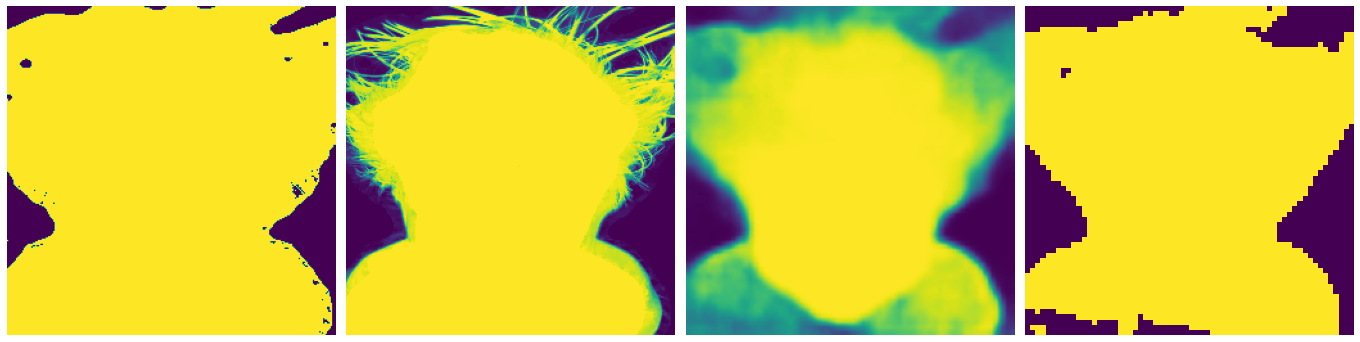

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(19,7))
plt.subplot(141)
# plt.imshow(img.squeeze(0)[:,:,:3])
plt.imshow(threImg[1])
plt.axis("off")

plt.subplot(142)
plt.imshow(mask)
plt.axis("off")

plt.subplot(143)
plt.imshow(cv2.resize(pred.squeeze(0).squeeze(-1), (256,256)))
plt.axis("off")

plt.subplot(144)
plt.imshow(thre[1])
plt.axis("off")

plt.tight_layout()
plt.show()

In [19]:
import numpy as np 
import cv2
# import matplotlib.pyplot as plt

img_ = cv2.imread("./dataset/selfie/testing/00160.png", cv2.IMREAD_COLOR)
img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
sap = img_.shape
img = cv2.resize(img_, (256,256))
img = img.astype(np.float32)
img = img[np.newaxis,:,:,:] / 255.

pred = model.predict(img)

In [22]:
# trues_ = tf.constant(img , dtype=tf.float32)
# preds_ = tf.constant(pred, dtype=tf.float32) 

# iou = iou_coef(trues_, preds_, smooth=1)

# with tf.Session()  as sess :
#     iou_ = sess.run(iou)
#     print(iou_)

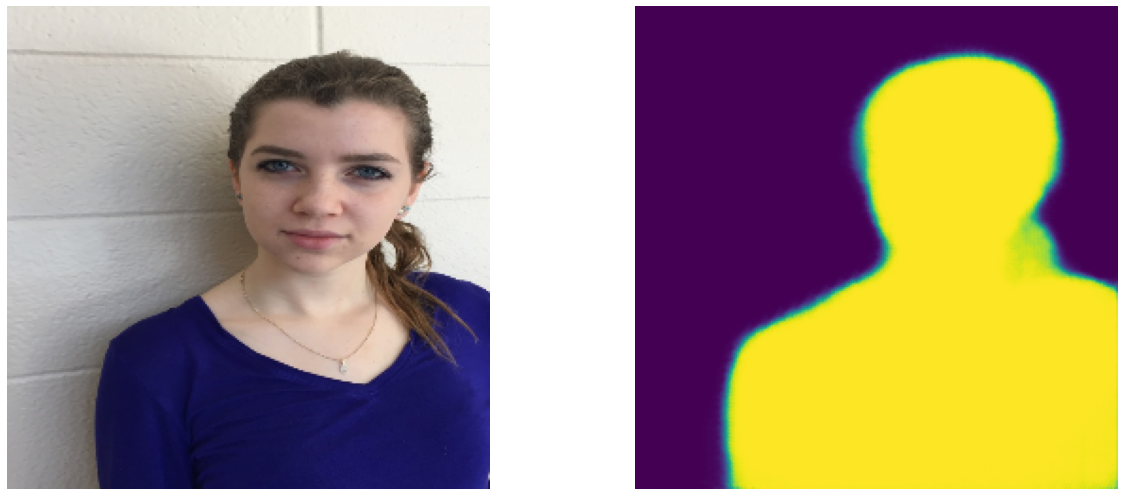

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(19,7))
plt.subplot(121)
plt.imshow(img.squeeze(0)[:,:,:3])
plt.axis("off")

plt.subplot(122)
plt.imshow(pred.squeeze(0).squeeze(-1))
plt.axis("off")

plt.tight_layout()
plt.show()

In [24]:
sap[0]

800

ValueError: cannot select an axis to squeeze out which has size not equal to one

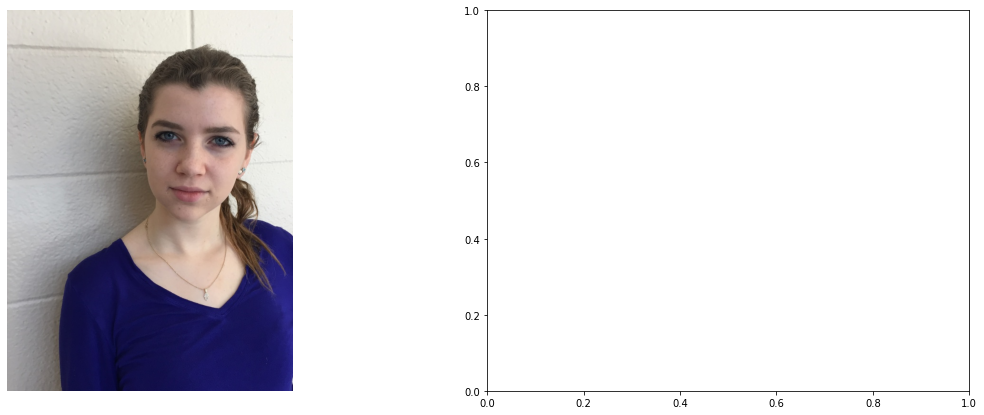

In [25]:
plt.figure(figsize=(19,7))
plt.subplot(121)
plt.imshow(img_[:,:,:3])
plt.axis("off")

plt.subplot(122)
plt.imshow(cv2.resize(pred[0].squeeze(0).squeeze(-1), (sap[1], sap[0])))
plt.axis("off")

plt.tight_layout()
plt.show()

In [42]:
# data feeding logic
test_params = {
            'dim': (256,256),
            'batch_size': 1,
            'n_channels': 3,
            'shuffle': False,
            'augment': False,
            'train' : False,
        }
paths = sorted([p for p in img_paths if 'test' in p])
gen = DataGeneratorMatting(paths, **test_params)

In [43]:
iou_list = []
for ge in gen:
    g, l = ge
    preds = model.predict(g, verbose=1)
    trues_ = tf.constant(l[0] , dtype=tf.float64)
    preds_ = tf.constant(preds, dtype=tf.float64) 

    iou = iou_coef(trues_, preds_, smooth=1)
    
    with tf.Session()  as sess : 
        iou_ = sess.run(iou)
        print(iou_)
        iou_list.append(iou_)



1/1 [==============================] - 0s 70ms/step
(array([37180], dtype=int32), array([37915], dtype=int32), 0.9806150437809895)
1/1 [==============================] - 0s 70ms/step
(array([39601], dtype=int32), array([40144], dtype=int32), 0.986474031635322)
1/1 [==============================] - 0s 75ms/step
(array([33521], dtype=int32), array([34106], dtype=int32), 0.9828480956988301)
1/1 [==============================] - 0s 76ms/step
(array([52051], dtype=int32), array([52833], dtype=int32), 0.9851989249347012)
1/1 [==============================] - 0s 72ms/step
(array([26328], dtype=int32), array([26715], dtype=int32), 0.9855142985476868)
1/1 [==============================] - 0s 79ms/step
(array([35303], dtype=int32), array([36360], dtype=int32), 0.9709303924534529)
1/1 [==============================] - 0s 67ms/step
(array([26557], dtype=int32), array([27243], dtype=int32), 0.9748201438848921)
1/1 [==============================] - 0s 69ms/step
(array([40631], dtype=int32), ar

(array([38682], dtype=int32), array([39594], dtype=int32), 0.9769667887359516)
1/1 [==============================] - 0s 68ms/step
(array([46165], dtype=int32), array([46930], dtype=int32), 0.9836994736954252)
1/1 [==============================] - 0s 68ms/step
(array([40564], dtype=int32), array([41530], dtype=int32), 0.9767402663070959)
1/1 [==============================] - 0s 68ms/step
(array([50096], dtype=int32), array([51165], dtype=int32), 0.9791072196380409)
1/1 [==============================] - 0s 68ms/step
(array([38810], dtype=int32), array([39305], dtype=int32), 0.9874065028239963)
1/1 [==============================] - 0s 69ms/step
(array([31570], dtype=int32), array([32160], dtype=int32), 0.9816547992910668)
1/1 [==============================] - 0s 68ms/step
(array([39930], dtype=int32), array([41601], dtype=int32), 0.9598336618431806)
1/1 [==============================] - 0s 68ms/step
(array([48338], dtype=int32), array([48912], dtype=int32), 0.9882648784576697)
1/1 

(array([35161], dtype=int32), array([36483], dtype=int32), 0.9637649380550378)
1/1 [==============================] - 0s 69ms/step
(array([38964], dtype=int32), array([40347], dtype=int32), 0.9657232080896203)
1/1 [==============================] - 0s 69ms/step
(array([36760], dtype=int32), array([37118], dtype=int32), 0.9903553436245589)
1/1 [==============================] - 0s 69ms/step
(array([26217], dtype=int32), array([26582], dtype=int32), 0.9862694203062108)
1/1 [==============================] - 0s 69ms/step
(array([45151], dtype=int32), array([46421], dtype=int32), 0.9726422816767912)
1/1 [==============================] - 0s 69ms/step
(array([32128], dtype=int32), array([33061], dtype=int32), 0.9717802915734075)
1/1 [==============================] - 0s 69ms/step
(array([53471], dtype=int32), array([55598], dtype=int32), 0.9617439162574867)
1/1 [==============================] - 0s 70ms/step
(array([43846], dtype=int32), array([44334], dtype=int32), 0.9889928950039473)
1/1 

(array([56261], dtype=int32), array([57092], dtype=int32), 0.9854448005885135)
1/1 [==============================] - 0s 70ms/step
(array([46834], dtype=int32), array([47072], dtype=int32), 0.9949440231130372)
1/1 [==============================] - 0s 70ms/step
(array([47790], dtype=int32), array([48414], dtype=int32), 0.9871114324073118)
1/1 [==============================] - 0s 69ms/step
(array([40173], dtype=int32), array([40666], dtype=int32), 0.9878771485479627)
1/1 [==============================] - 0s 71ms/step
(array([42818], dtype=int32), array([43210], dtype=int32), 0.9909282358658675)
1/1 [==============================] - 0s 70ms/step
(array([42334], dtype=int32), array([42726], dtype=int32), 0.9908254733540852)
1/1 [==============================] - 0s 69ms/step
(array([49662], dtype=int32), array([50249], dtype=int32), 0.988318407960199)
1/1 [==============================] - 0s 70ms/step
(array([46718], dtype=int32), array([47287], dtype=int32), 0.9879673490103198)
1/1 [

(array([31867], dtype=int32), array([32430], dtype=int32), 0.9826400666029417)
1/1 [==============================] - 0s 68ms/step
(array([21663], dtype=int32), array([22259], dtype=int32), 0.9732255166217431)
1/1 [==============================] - 0s 81ms/step
(array([32393], dtype=int32), array([33178], dtype=int32), 0.9763404563127279)
1/1 [==============================] - 0s 69ms/step
(array([33460], dtype=int32), array([35361], dtype=int32), 0.9462417284090267)
1/1 [==============================] - 0s 74ms/step
(array([37861], dtype=int32), array([38743], dtype=int32), 0.9772351848028081)
1/1 [==============================] - 0s 76ms/step
(array([22335], dtype=int32), array([22766], dtype=int32), 0.9810690912285325)
1/1 [==============================] - 0s 71ms/step
(array([31890], dtype=int32), array([32616], dtype=int32), 0.9777416684551001)
1/1 [==============================] - 0s 70ms/step
(array([33490], dtype=int32), array([34692], dtype=int32), 0.9653532412878679)
1/1 

In [96]:
paths[270]

'./dataset/selfie/testing/00271.png'

In [95]:
iou_list[270]

(array([50393], dtype=int32), array([54093], dtype=int32), 0.9316005471956225)

In [59]:
lowest = np.argsort(np.array([i[-1] for i in iou_list]))[:50]

In [75]:
lowest[:20]

array([207, 241, 183, 270, 292, 221,  31, 235,  48,  62, 199, 217,  33,
        12,  61, 255, 114,  56,  42,  84])

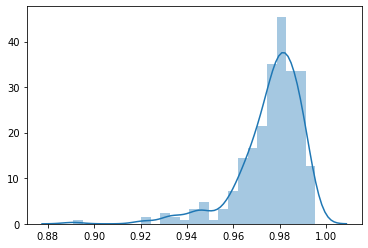

In [47]:
sns.distplot([i[-1] for i in iou_list])

In [74]:
iou_list[84]

(array([44792], dtype=int32), array([47103], dtype=int32), 0.9509383491847826)

In [70]:
[iou_list[l] for l in lowest]

[(array([32086], dtype=int32),
  array([36016], dtype=int32),
  0.8908848599272565),
 (array([21803], dtype=int32),
  array([23678], dtype=int32),
  0.9208159128341569),
 (array([53640], dtype=int32),
  array([58159], dtype=int32),
  0.9223005502063274),
 (array([50393], dtype=int32),
  array([54093], dtype=int32),
  0.9316005471956225),
 (array([34492], dtype=int32),
  array([37009], dtype=int32),
  0.9319913536881924),
 (array([49978], dtype=int32),
  array([53590], dtype=int32),
  0.9326006232389767),
 (array([47096], dtype=int32),
  array([50401], dtype=int32),
  0.9344272052696322),
 (array([27445], dtype=int32),
  array([29370], dtype=int32),
  0.9344591603963093),
 (array([38977], dtype=int32),
  array([41568], dtype=int32),
  0.9376698982414781),
 (array([33289], dtype=int32),
  array([35354], dtype=int32),
  0.9415924197426107),
 (array([38513], dtype=int32),
  array([40882], dtype=int32),
  0.9420541545385612),
 (array([34386], dtype=int32),
  array([36422], dtype=int32),
  0

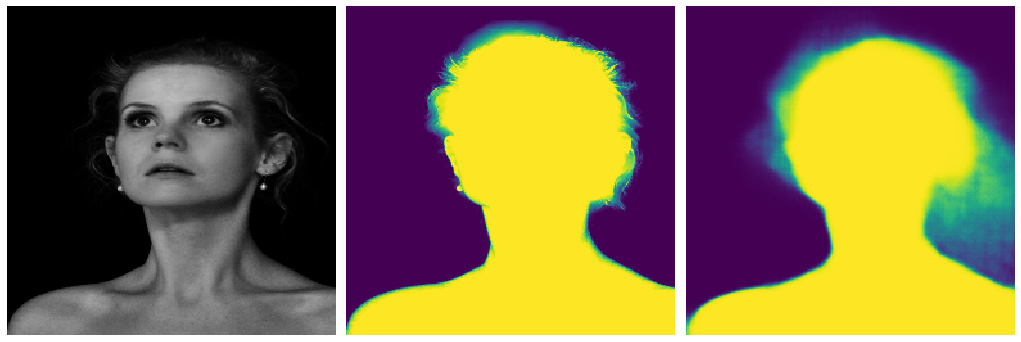

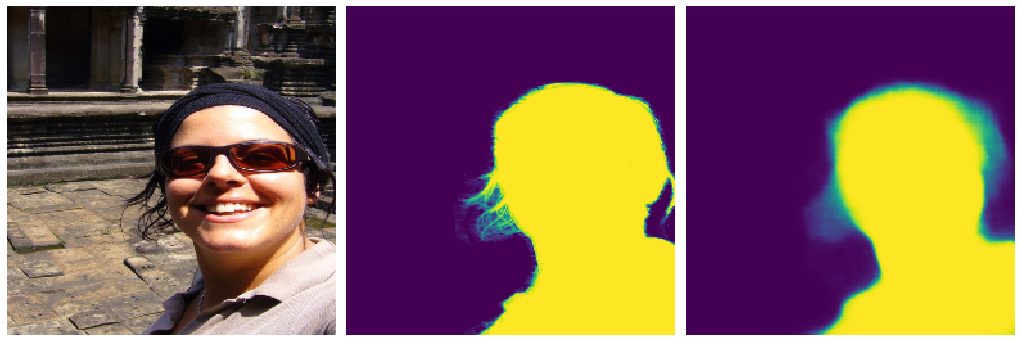

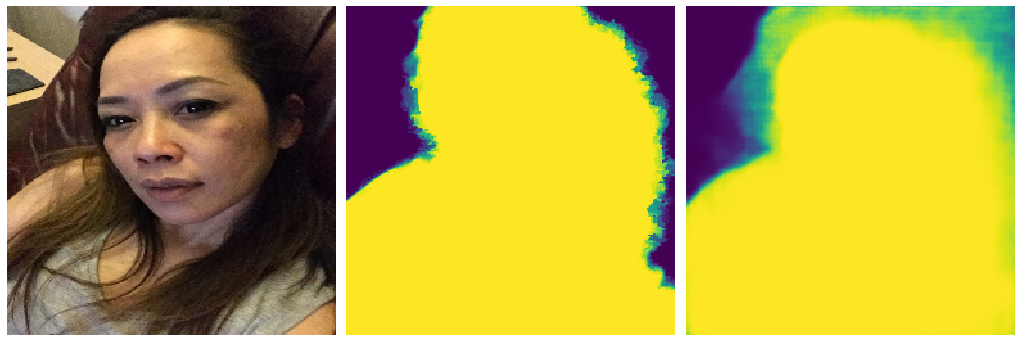

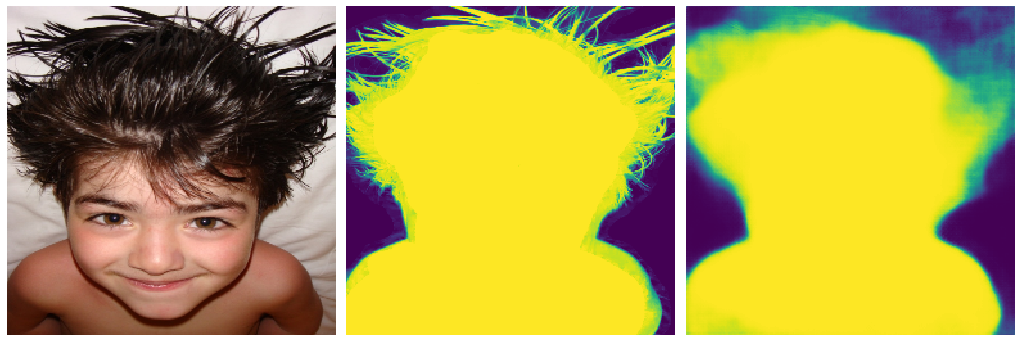

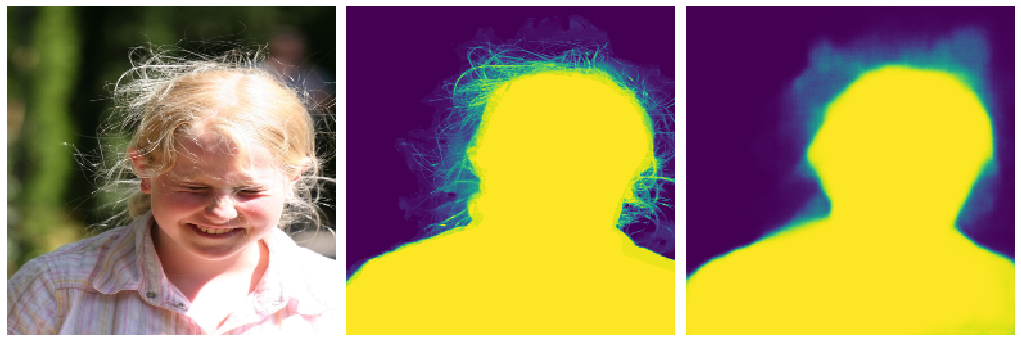

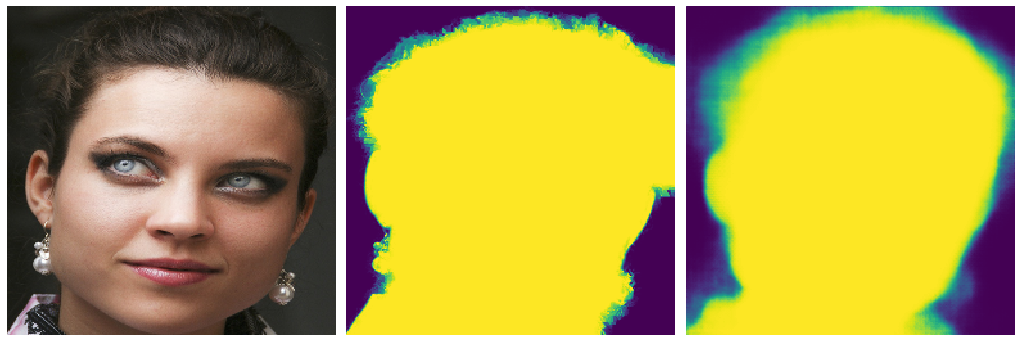

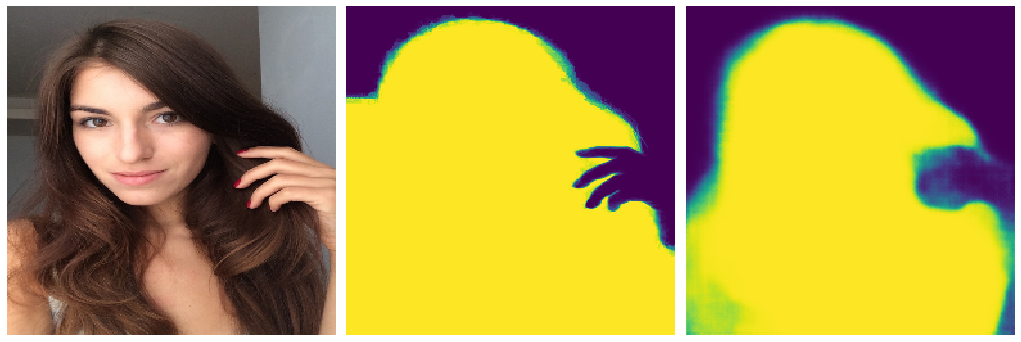

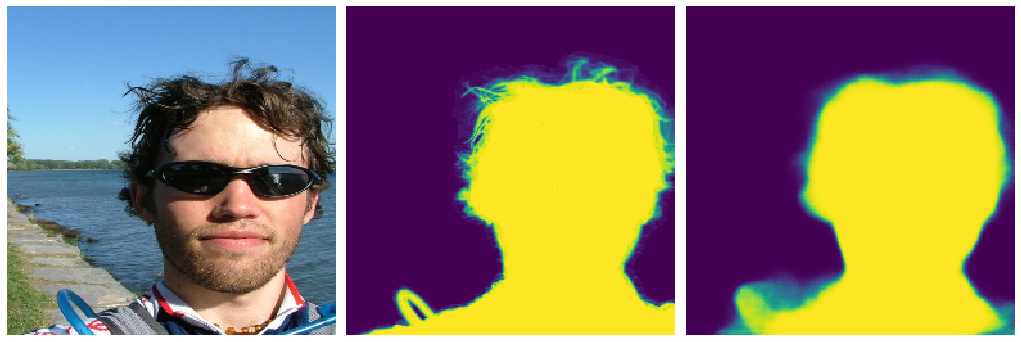

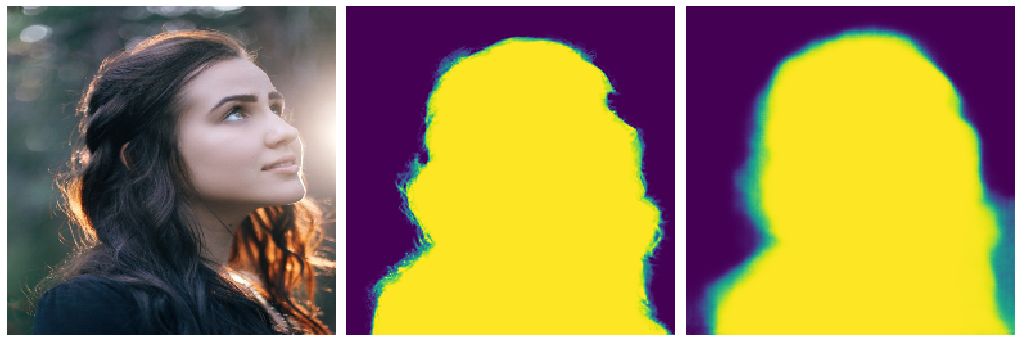

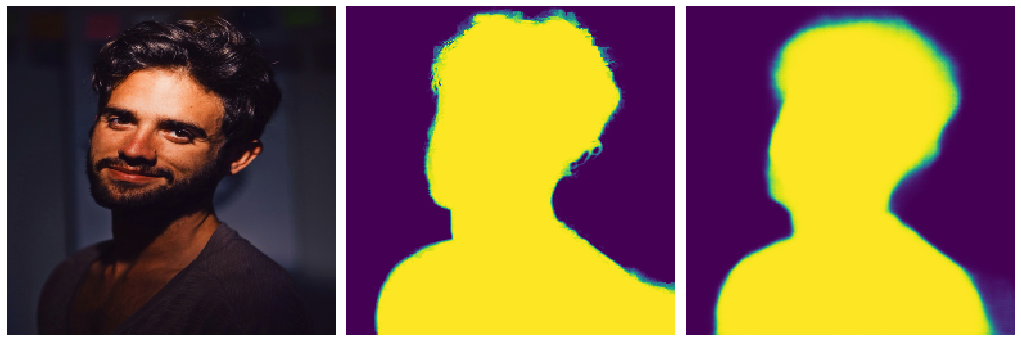

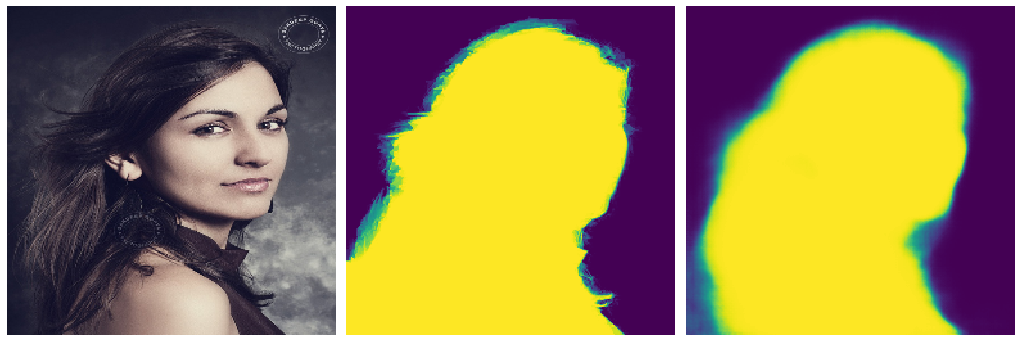

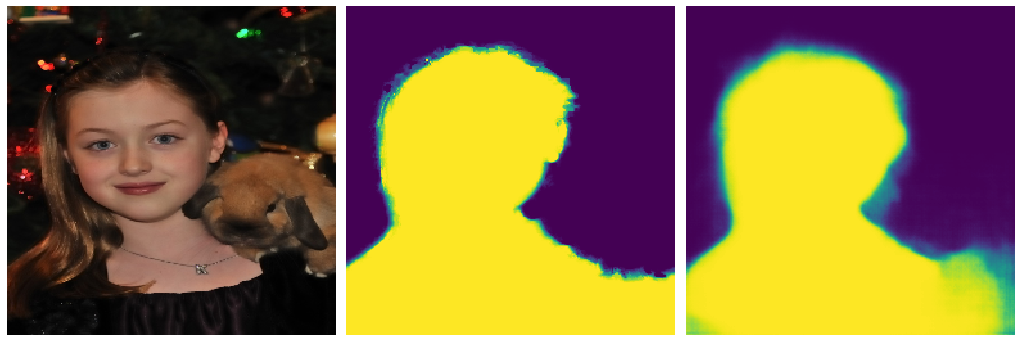

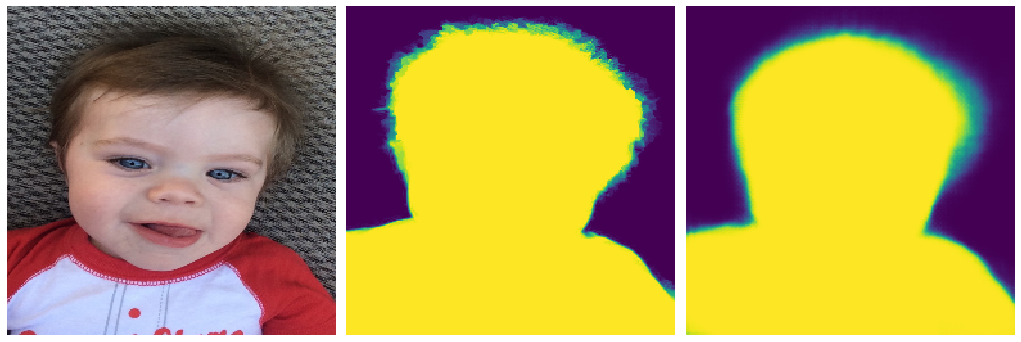

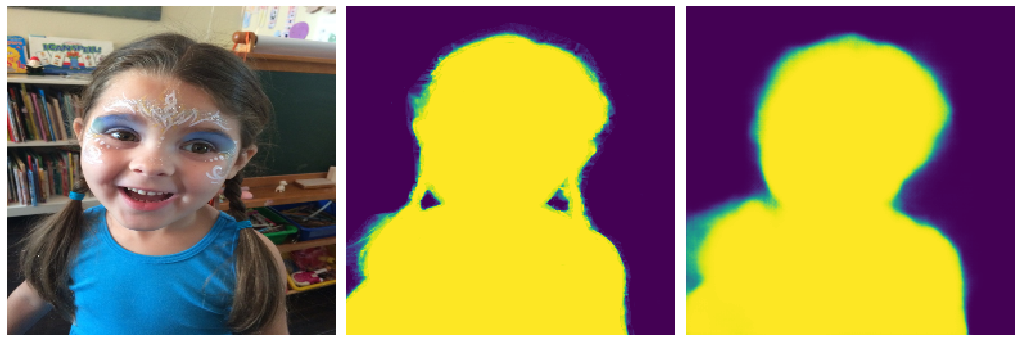

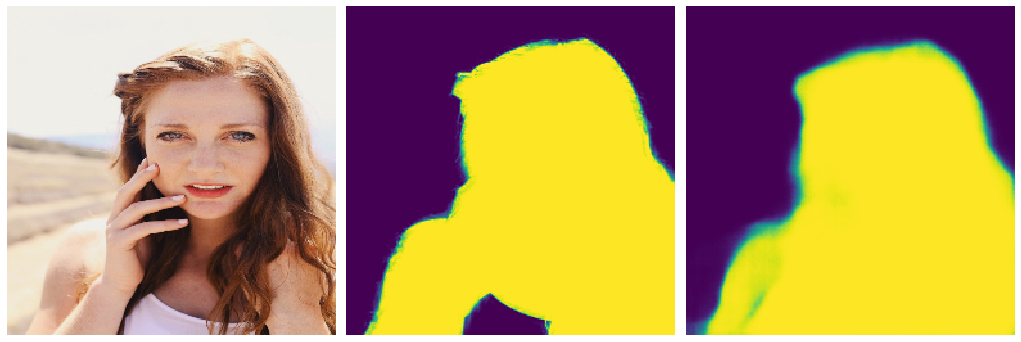

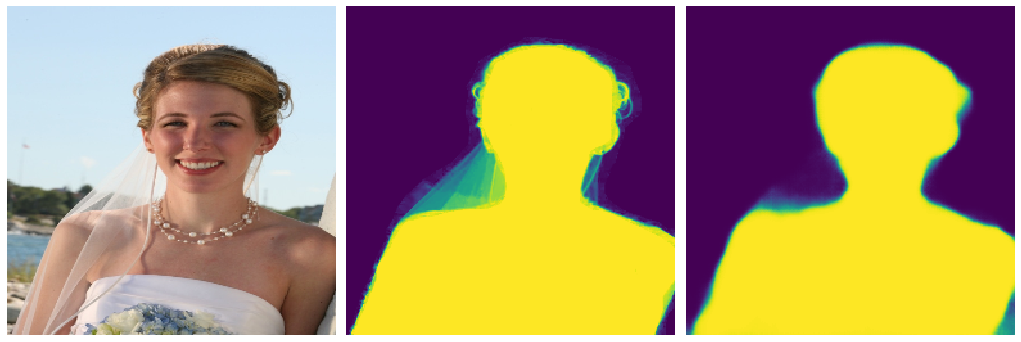

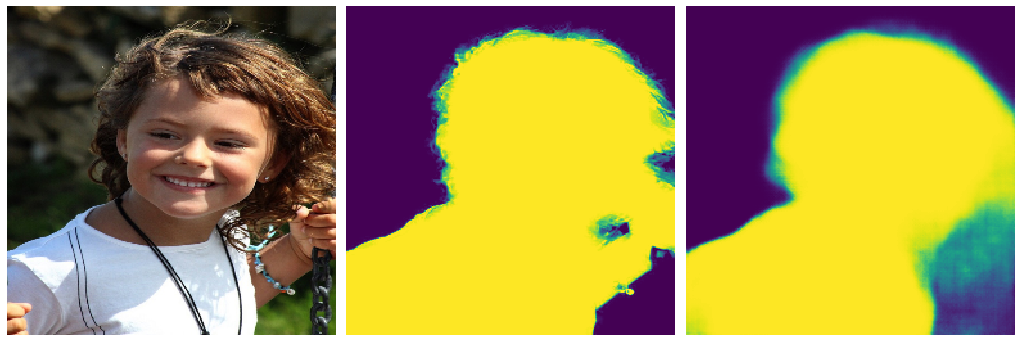

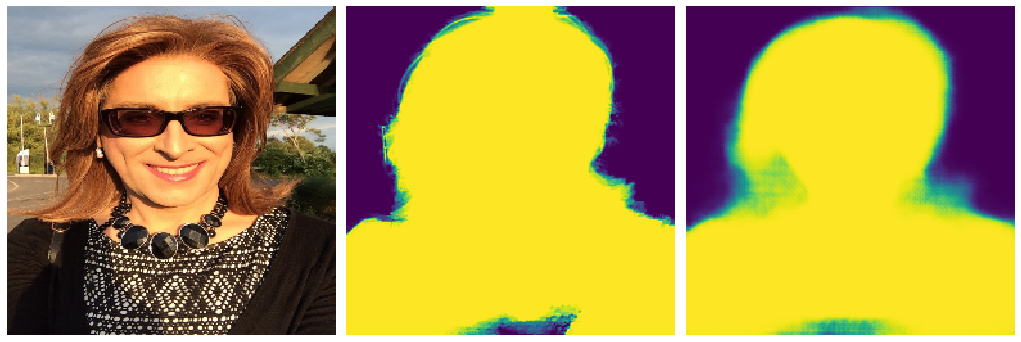

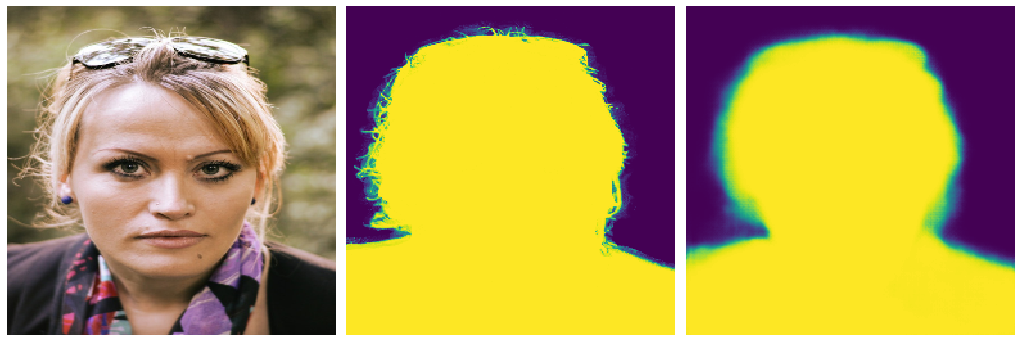

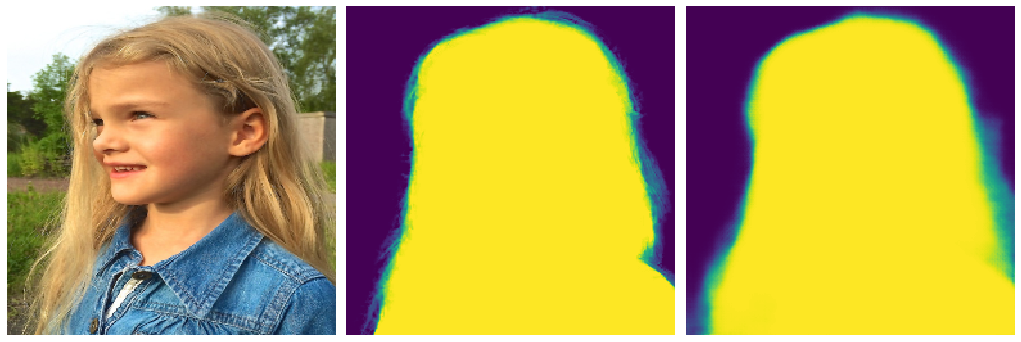

In [79]:
import numpy as np 
import cv2
# import matplotlib.pyplot as plt
for i in lowest[:20]:
    img_path = paths[i]
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256,256))
    # img = np.concatenate([img, np.ones((256,256,1))], axis=-1)[np.newaxis,:,:,:] / 255.
    img = img.astype(np.float32)
    img = img[np.newaxis,:,:,:] / 255.

    mask_path = img_path.split(".p")[0] + "_matte.png"
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (256,256))

    pred = model.predict(img)
    
    plt.figure(figsize=(19,7))
    plt.subplot(141)
    plt.imshow(img.squeeze(0)[:,:,:3])
    plt.axis("off")

    plt.subplot(142)
    plt.imshow(mask)
    plt.axis("off")

    plt.subplot(143)
    plt.imshow(pred.squeeze(0).squeeze(-1))
    plt.axis("off")

    # plt.subplot(144)
    # plt.imshow(pred[1].squeeze(0).squeeze(-1))
    # plt.axis("off")

    plt.tight_layout()
    plt.show()

In [84]:
paths.index('./dataset/selfie/testing/00260.png')

259

In [82]:
[i for i in img_paths if '00260' in i]

['./dataset/selfie/testing/00260.png', './dataset/selfie/training/00260.png']